# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Открытие файла с данными и изучение общей информации

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

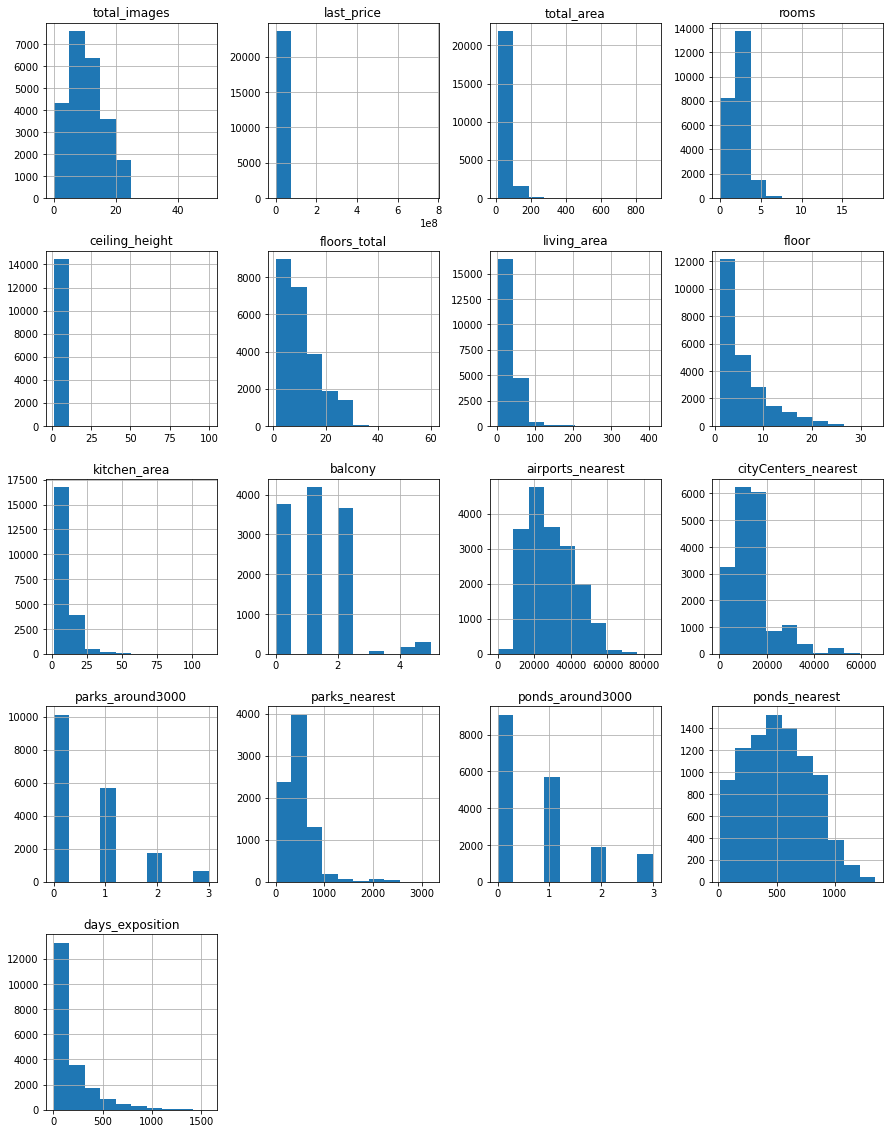

In [3]:
data.hist(figsize=(15, 20));

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

#pd.set_option('display.max_columns', None)
#pd.set_option('display.float_format', '{:.0f}'.format)


data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

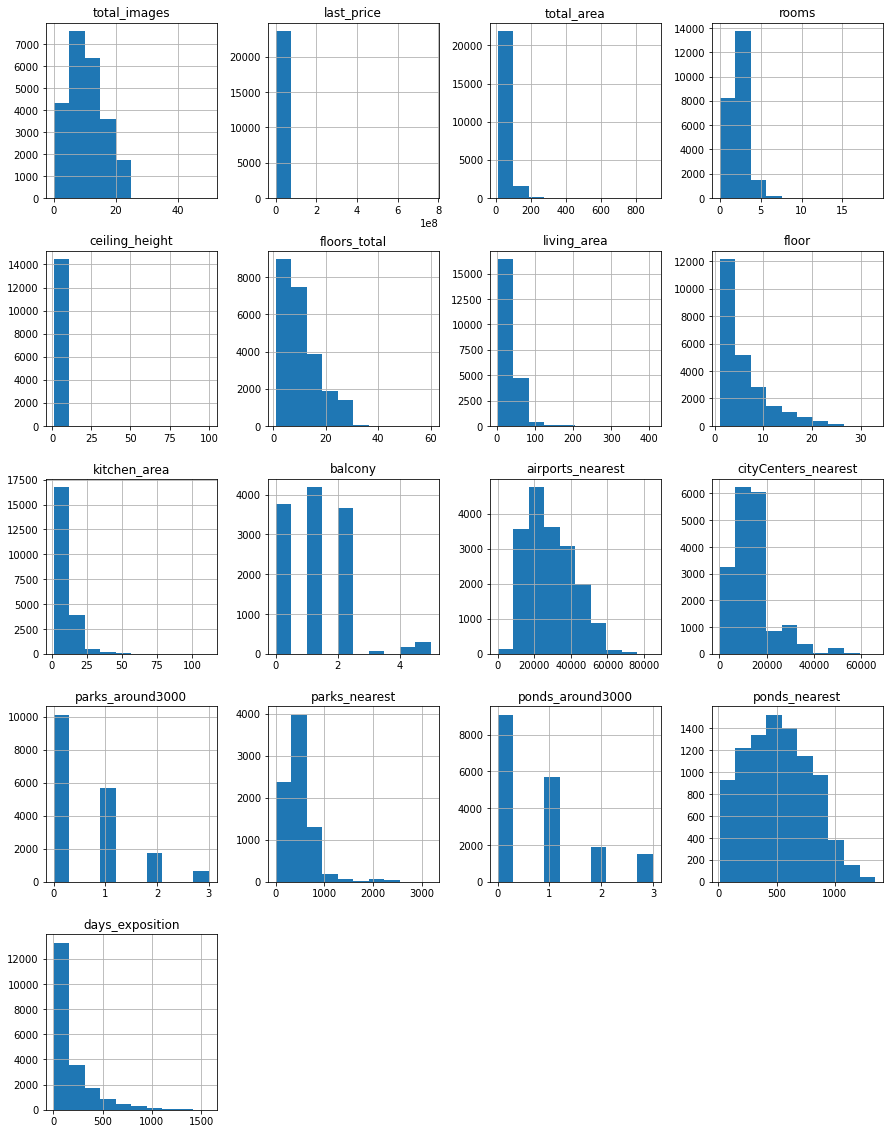

In [6]:
data.hist(figsize=(15, 20));

#### Промежуточный вывод для пункта №1

Исходя из полученной информации после вызова метода info(), можно отметить, что во многих столбцах не хватает значений, а также неверно определен тип столбцов, что необходимо исправить.

### Предобработку данных

Для удобства выведем общую информацию о датасете при помощи `info()`:

In [7]:
data.info()
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


Рассмотрим столбцы, в которых имеются пропуски, т.е. количество ненулевых значений не равно общему числу строк (23699), и сразу будем их убирать, если это потребуется.

#### Проверим наличие явных дубликатов

In [8]:
data.duplicated().unique()

array([False])

Так как массив уникальных значений состоит из False, можно с уверенностью сказать, что в датасете нет явных дубликатов. 

#### Высота потолков

In [9]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Для начала исправим заведомо невозможные значения: к примеру, если высота потолков 27.5, то это явный выброс/ошибка. Какая природа происхождения такой ошибки? Возможно, сам продавец неправильно поставил точку в объявлении, или при скачивании и архивировании произошли какие-то иные ошибки, из-за чего некорректные данные попали в датасет. Исправить это просто - разделим слишком большие значения на 10. 

Заметим, что в датасете встречается очень большое число - 100. Как обработать такую ошибку? Потолки высотой 10 метров или 1? Очевидно, ни первое, и ни второе. Это выброс. Будем заменять подобные большие числа на медианное - 2 метра 65 сантиметров.

In [10]:
data.loc[data['ceiling_height'] >= 10, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 10, 'ceiling_height'].apply(lambda x: x / 10)
data.loc[(data['ceiling_height'] < 2) | (data['ceiling_height'] > 30), 'ceiling_height'] = data['ceiling_height'].median()

Заметим, что в этом столбце очень большое количество является NaN. Пока неизвестно, с чем это связано. Так как у большинства квартир примерно одинаковая высота потолков, заменим NaN на медианное значение.

In [11]:
#data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

data['ceiling_height'].unique()

array([ 2.7 ,   nan,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  2.65,  3.2 ,  2.61,  3.25,  3.45,
        2.77,  2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,
        2.47,  2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,
        2.51,  2.78,  2.76,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,
        2.59,  2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,
        3.55,  3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.3 ,
        5.  ,  2.79,  2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,
        4.7 ,  2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,
        2.3 ,  3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,
        3.95,  3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,
        3.24,  4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,  3.07,  3.37,
        3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,
        2.68,  3.22,  3.27,  4.1 ,  2.93,  3.46,  3.47,  3.33,  3.63,
        3.32,  8.3 ,

#### Общее количество этажей в доме

Следующий столбец, которые имеет пропуски - `floors_total`. Заметим, что ненулевых значений 23613, т.е. всего лишь в 86 объявлениях не был указана этажность дома. Для такой большой выборки, как у нас, это достаточно мало, а значит, эти строки не практически не повлияют на результаты при исследовании. Заполним их медианным значением.

In [12]:
data = data.dropna(subset=['floors_total'])

Также отметим, что дробного числа этажей быть не может. Значит, нужно исправить тип данных в таблице.

In [13]:
data['floors_total'] = data['floors_total'].astype(int)

In [14]:
data['floors_total'].dtype

dtype('int64')

Причина возникновения пропуска, скорее всего, ошибка в заполнении объявления, так как этажность дома - важная вещь. Также таких пропусков всего 86, что подтверждает это предположение.

#### Жилая площадь

21796 - именно столько значений в столбце `living_area` ненулевые. То есть, чуть больше 8% всех значений потеряны. Уже более весомо, чем 80 значений прошлого столбца. 

Причина возникновения такого большого количества NaN проста - продавцы просто не указали это значение, т.е. виноват человеческий фактор. 

Заполнить медианным/средним значением пропуски не получится - данные сильно исказятся. 
Обратим внимание на столбец `total_area`: в нем пропусков не имеется. Значит общая площадь заполнена во всех объявлениях, а жилая - в 92% объявлений. Значит, отсутствие значений в столбце с жилой площадью не сильно повлияет на результат исследования.

In [15]:
data['living_area'].isna().sum()

1870

In [16]:
data['living_area'].describe()

count    21743.000000
mean        34.462781
std         22.037433
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Жилая площадь - 2 м^2? Такое возможно? Посмотрим на такие маленькие данные:

In [17]:
data.sort_values(by='living_area', ascending=True).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,NaN,24,2.0,22,NaN,...,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.0,6,2.0,2,NaN,...,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,NaN,17,3.0,17,NaN,...,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.0,8,3.0,8,NaN,...,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0
17582,11,2680000.0,22.0,2018-08-11T00:00:00,0,NaN,25,5.0,8,NaN,...,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
21943,15,6100000.0,77.6,2019-02-28T00:00:00,4,2.5,9,5.4,1,NaN,...,9.8,NaN,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0
16431,13,3799000.0,31.0,2018-04-12T00:00:00,1,2.6,5,6.0,1,NaN,...,17.0,NaN,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0
19251,19,4050000.0,33.0,2018-10-15T00:00:00,1,2.5,22,6.5,21,NaN,...,18.0,NaN,Санкт-Петербург,9258.0,10592.0,1.0,458.0,0.0,NaN,44.0
23208,12,4800000.0,37.0,2016-02-24T00:00:00,1,NaN,14,8.0,11,NaN,...,22.0,0.0,Санкт-Петербург,27838.0,12387.0,2.0,358.0,1.0,950.0,139.0
20994,7,8900000.0,50.6,2018-10-22T00:00:00,2,2.5,7,8.0,3,NaN,...,31.0,NaN,Санкт-Петербург,12771.0,8301.0,1.0,173.0,3.0,126.0,NaN


Рассматривая информацию по квартире с очень маленькой жилплощадью, можно сделать вывод, что это ошибка, и она была допущена при вводе данных. Скорее всего, там 20кв метров, а не 2.
Заполнить пропуски не удастся, так как это не какое-то абстрактное значение, а вполне конкретная дискретная величина - площадь.
Подобных данных не очень много, а значит они также не повлияют на исследование.

Как возникли пустые значения в количестве 8% от всех значений? Снова ошибка в заполнении. Продавец ввел общую площадь квартиры, но забыл про жилплощадь.

#### Общая площадь

In [18]:
data['total_area'].describe()

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

Заметим, что максимальное значение выглядит подозрительно.
Посмотрим, что там:

In [19]:
data.query('total_area == 900.0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.8,25,409.7,25,NaN,...,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Квартира почти за полмиллиарда и из 12 комнат? Звучит, конечно, необычно, но исключать такое нельзя - такие квартиры тоже бывают. Так как в большинстве исследовательских манипуляций мы используем инструменты, устойчивые к выбросам, это значение можно оставить.

#### Площадь кухни

In [20]:
data['kitchen_area'].isna().sum() #т.к. полученный столбец состоит из True и False, то при суммировании мы получим число строк,
# в которых не указана площадь кухни.

2231

Как и с предыдущими столбцами с площадью чего-либо, этот придется оставить с пропусками.

#### Цена объекта

In [21]:
data['last_price'].describe()

count    2.361300e+04
mean     6.540555e+06
std      1.090172e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Если смотреть цены на квартиры в пределах 20 миллионов и более, то распределение похоже на Пуассона.
Больше всего квартир в этом ценовом диапазоне - на отметке в 4млн. Далее выбросы: самая дорогая квартира стоит более 760 млн.

In [22]:
data.query('last_price == 763_000_000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.0,400.0,2017-09-30T00:00:00,7,NaN,10,250.0,10,NaN,...,NaN,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0


 Параметры квартиры не выглядят странно, она пригодна для изучения.
 
 Как и в предыдущем столбце с площадью, значение хоть и является выбросом, но не сильно повлияет на результаты исследования.

#### Количество комнат

In [23]:
data['rooms'].describe()

count    23613.000000
mean         2.071147
std          1.078380
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

0 комнат? Непорядок...

У квартиры должна быть хотя бы одна комната (даже если это студия), заменим нуля на единицы. 

In [24]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

#### Балконы

Во многих объявлениях не указано число балконов - вместо этого стоит NaN. Так как балкон достаточно важная часть квартиры, будем считать, что отсутствующие значения == отсутствующий балкон. Заменим подобные значения на 0.

Также приведем данные к типу int64.

In [25]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype(int)

data['balcony'].describe()


count    23613.000000
mean         0.593063
std          0.960307
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

#### Названия

In [26]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [27]:
data = data.apply(lambda x: x.replace({'поселок':'посёлок', 
                                   'городской посёлок': 'посёлок', 'посёлок городского типа': 'посёлок', 
                                   'коттеджный посёлок': 'посёлок', 
                                   'посёлок при железнодорожной станции': 'посёлок станции'}, regex=True))


data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок Лебяжье', 'посёлок Сиверский', 'посёлок Молодцово',
       'посёлок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'посёлок Торковичи', 'посёлок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород',

#### Формат даты публикации

In [28]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')

#### Апартаменты

In [29]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Видим NaN, думаем: откуда он мог взятся.

Тут все просто - если квартира и так не является апартаментами, то зачем это указывать. Так подумало абсолютное большинство продавцов и теперь мы имеем столбец с самым большим процентом пропуском.

Исправим это:

In [30]:
data['is_apartment'] = data['is_apartment'].fillna(False)

In [31]:
data['is_apartment'].astype(bool)

0        False
1        False
2        False
3        False
4        False
         ...  
23694    False
23695    False
23696    False
23697    False
23698    False
Name: is_apartment, Length: 23613, dtype: bool

In [32]:
data['open_plan'].unique()

array([False,  True])

#### Ближайшие аэропорты

Так как заполнить средними или медианными значениями подобные пропуски нельзя, заполним нулями. При проведении исследования такие значения учитываться не будут.

In [33]:
data['airports_nearest'] = data['airports_nearest'].fillna(0)

#### Ближайшие городские центры

In [34]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)

#### Парки в пределах 3 км

In [35]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)

#### Ближайшие парки

In [36]:
data['parks_nearest'] = data['parks_nearest'].fillna(0)

#### Озера в пределах 3 км

In [37]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

#### Ближайшие озера

In [38]:
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)

#### От публикации до продажи

In [39]:
data['days_exposition'].isna().sum()

3172

Более 10% объявлений из архива не имеют значения в этом столбце. Такой столбец заполнялся автоматически, а значит возможных причин две: ошибка при загрузке или обработке данных и более простой - квартира так и не была продана на момент создания датасета. 

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

#### Промежуточный вывод для пункта №2

При выполнении предобработки датасета был досконально исследован каждый столбец и исправлены проблемы там, где это требовалось.

Выбросы и ошибки были изучены, их природа объяснена.

Исправлены типы данных в стобцах, где это было необходимо - `rooms`, `first_day_exposition` и другие.
Были удалены повторяющиеся значения в стобце `locality_name` - местоположение квартиры. Данный параметр является одним из самых важных при покупке квартиры, ведь люди в первую очередь смотрят на город, а уже после на цену и метраж.

### Добавление в таблицу новых столбцов

#### Цена одного квадратного метра

In [41]:
def price_of_a_metre(price, area):
    metre_price = price / area
    return round(metre_price, 2)

data['price_of_a_metre'] = data.apply(lambda x: price_of_a_metre(x['last_price'], x['total_area']), axis=1)

In [42]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
data['day_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

In [43]:
def type_of_floor(floor, floors_total):
    if floor == floors_total:
        return 'последний'
    elif floor == 1:
        return 'первый'
    else:
        return 'другой'
    
data['type_of_floor'] = data.apply(lambda x: type_of_floor(x['floor'], x['floors_total']), axis=1)

In [44]:
def distance_to_the_center(distance):
    return round(distance / 1000)

data['distance_to_the_center'] = data['cityCenters_nearest'].apply(distance_to_the_center)

In [45]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_a_metre,day_exposition,month_exposition,year_exposition,type_of_floor,distance_to_the_center
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,0.0,0.0,0.0,81.0,82920.79,1,12,2018,первый,19
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8


#### Промежуточны вывод для пункта №3

В данном разделе были написаны функции `price_of_a_metre` (цена метра в данной квартире), `type_of_floor` (тип этажа) и `distance_to_the_center` (расстояние до центра). Созданы новые столбцы путем применения этих методов к уже существуеющим столбцам. В дальнейшем это поможет при исследовательском анализе.

### Исследовательский анализ данных

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23613 non-null  int64         
 1   last_price              23613 non-null  float64       
 2   total_area              23613 non-null  float64       
 3   first_day_exposition    23613 non-null  datetime64[ns]
 4   rooms                   23613 non-null  int64         
 5   ceiling_height          14495 non-null  float64       
 6   floors_total            23613 non-null  int64         
 7   living_area             21743 non-null  float64       
 8   floor                   23613 non-null  int64         
 9   is_apartment            23613 non-null  bool          
 10  studio                  23613 non-null  bool          
 11  open_plan               23613 non-null  bool          
 12  kitchen_area            21382 non-null  float6

#### Общая площадь

Посмотрим, как распределяется количество объявлений в зависимости от общей площади квартиры:

Построим гистограмму, исключив очень большие значения при помощи параметра `range`.

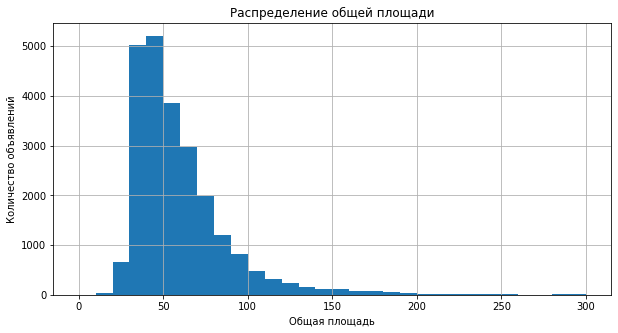

In [47]:
area_hist = data['total_area'].hist(bins=30, range=(0, 300), figsize=(10, 5))
area_hist.set_title('Распределение общей площади')
area_hist.set_xlabel('Общая площадь')
area_hist.set_ylabel('Количество объявлений')

plt.show()

Распределение с явным смещением влево. Достаточно внушительная часть квартир (более 10 тысяч) имеют площадь менее 50 квадратных метров. Приблизительно такое же количество квартир имеют площадь от 50 до 100 кв м.

Проверим это предположение, взглянув на квартили распределения:

In [48]:
data['total_area'].describe()

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

##### Промежуточный вывод

Исходя из изученных данных, можно сделать вывод о том, что основная масса (около половины) проданных квартир в Санкт-Петербурге и его окрестностях имеют площадь порядка 50 кв м. Четверть всех значений (от 50% до 75%) лежат между 52 и 70 квадратами.
Подавляющее большинство продаваемых квартир имеют площадь менее 70 кв м.

#### Жилая площадь

Построим гистограмму, аналогично с прошлым пунктом.

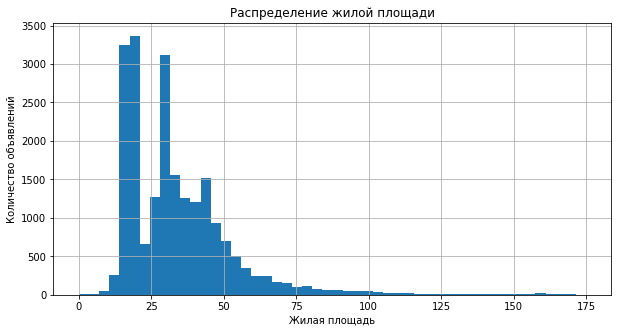

In [49]:
living_area_hist = data['living_area'].hist(bins=50, range=(0, 175), figsize=(10, 5))
living_area_hist.set_title('Распределение жилой площади')
living_area_hist.set_xlabel('Жилая площадь')
living_area_hist.set_ylabel('Количество объявлений')

plt.show()

##### Промежуточный вывод

Явных закономерностей в распределении не имеется, зато имеются несколько (на первый взгял) выбросов. На отметках приблизительно 20 и 28 квадратных метров имеются два пика. С чем это может быть связано? Скорее всего, это стандартный размер жилплощади для типовых квартир. Очеивидно, что таких квартир действительно большое количество, а значит и число типовых значений тоже будет велико.

#### Площадь кухни

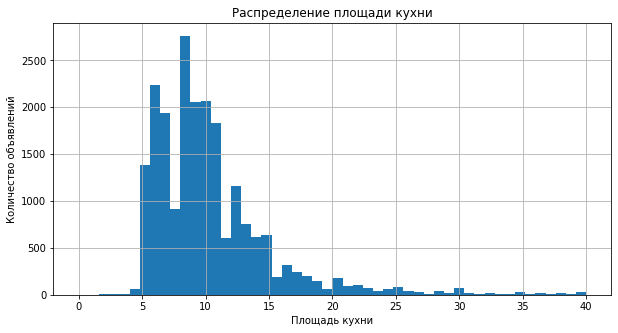

In [50]:
kitchen_area_hist = data['kitchen_area'].hist(bins=50, range=(0, 40), figsize=(10, 5))
kitchen_area_hist.set_title('Распределение площади кухни')
kitchen_area_hist.set_xlabel('Площадь кухни')
kitchen_area_hist.set_ylabel('Количество объявлений')

plt.show()

##### Промежуточный вывод

Снова видны пики - 6, 8 метров и небольшой на 13. Причина та же - это стандартные размеры подобных помещений в типовых квартирах.

#### Цена объекта

Самый интересный пункт в данном исследовании - цена.
Посмотрим, как она распределяется.

###### До 10 млн

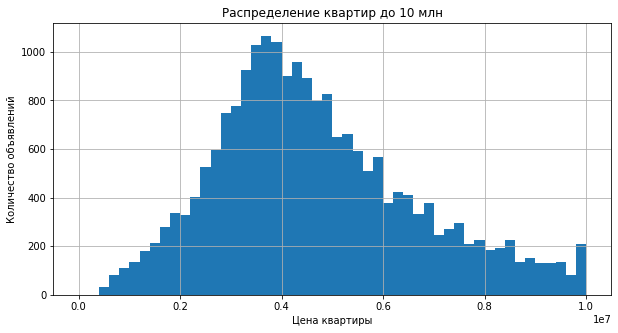

In [51]:
last_price_hist = data['last_price'].hist(bins=50, range=(0, 10_000_000), figsize=(10, 5))
last_price_hist.set_title('Распределение квартир до 10 млн')
last_price_hist.set_xlabel('Цена квартиры')
last_price_hist.set_ylabel('Количество объявлений')

plt.show()

Распределение цен на квартиры в пределах 10 млн напоминает нормальное. 

Квартир, стоимостью менее 4 млн рублей практически 9 тысяч:

In [52]:
len(data.query('last_price < 4_000_000'))

8810

И практически 12000 квартир располагаются в ценовом диапазоне от 4 до 10 млн:

In [53]:
len(data.query('last_price > 4_000_000 and last_price < 10_000_000'))

11776

###### От 10 до 30 млн

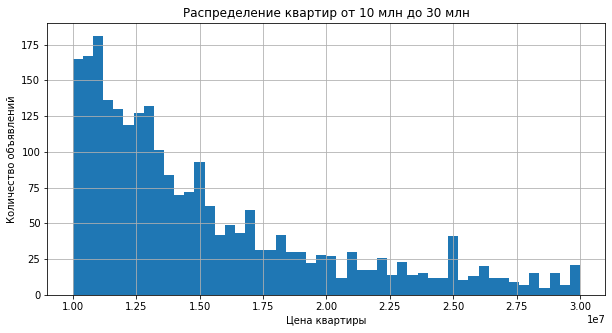

In [54]:
last_price_hist = data['last_price'].hist(bins=50, range=(10_000_000, 30_000_000), figsize=(10, 5))
last_price_hist.set_title('Распределение квартир от 10 млн до 30 млн')
last_price_hist.set_xlabel('Цена квартиры')
last_price_hist.set_ylabel('Количество объявлений')

plt.show()

Более дорогих квартир уже сильно меньше:

In [55]:
len(data.query('10_000_000 <= last_price <= 30_000_000'))

2452

###### От 30 до 100 млн

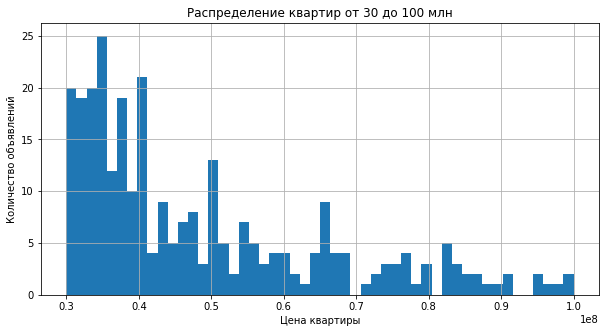

In [56]:
last_price_hist = data['last_price'].hist(bins=50, range=(30_000_000, 100_000_000), figsize=(10, 5))
last_price_hist.set_title('Распределение квартир от 30 до 100 млн')
last_price_hist.set_xlabel('Цена квартиры')
last_price_hist.set_ylabel('Количество объявлений')

plt.show()

In [57]:
len(data.query('30_000_000 <= last_price <= 100_000_000'))

288

###### От 100 до 800 млн

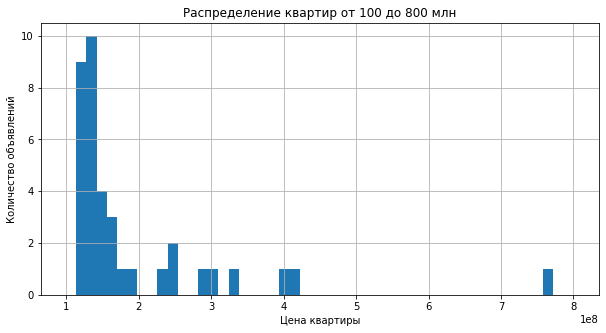

In [58]:
last_price_hist = data['last_price'].hist(bins=50, range=(100_000_000, 800_000_000), figsize=(10, 5))
last_price_hist.set_title('Распределение квартир от 100 до 800 млн')
last_price_hist.set_xlabel('Цена квартиры')
last_price_hist.set_ylabel('Количество объявлений')

plt.show()

In [59]:
len(data.query('100_000_000 <= last_price <= 800_000_000'))

37

##### Промежуточный вывод

Более 20000 объявлений расположены в диапазоне до 10 млн - свыше 87% всех объявлений. \
От 10 до 30 млн - 2466 квартир, чуть больше 10%. \
От 30 до 100 млн значений уже совсем мало: 289, что совсем немногим больше 1%. \
Боле 100 млн - всего 37 квартир. \

Сразу можно сказать, что основное исследование будет проводиться на данных, цена квартир в которых менее 30 млн рублей, так как это около 97% значений. Более крупные числа на исследования не повлияют, их слишком мало.

#### Количество комнат

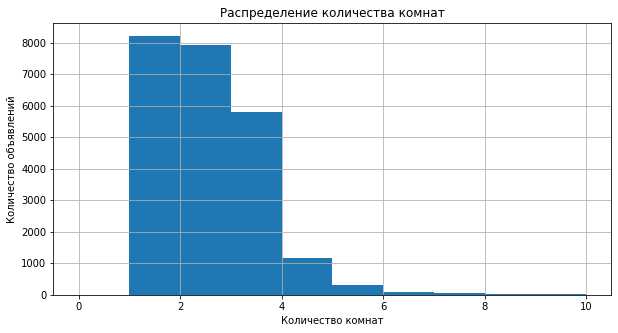

In [60]:
rooms_hist = data['rooms'].hist(bins=10, range=(0, 10), figsize=(10, 5))
rooms_hist.set_title('Распределение количества комнат')
rooms_hist.set_xlabel('Количество комнат')
rooms_hist.set_ylabel('Количество объявлений')

plt.show()

In [61]:
len(data.query('rooms <= 4'))

23094

In [62]:
data['rooms'].describe()

count    23613.000000
mean         2.079363
std          1.066311
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

##### Промежуточный вывод

Более 97% всех квартир имеют 4 и менее комнат, исследование будет строиться именно на них. \
Имеются большие значение, но при построении диаграммы они не учитывались для наглядности. Они не будут учитываться при исследовании.

Также, исходя из графика очевидно, что преобладают однокомнатные квартиры. Но стоит отметить, что такой результат получился в том числе из-за того, что мы убрали квартиры с 0 комнат, заменив их на однушки. Скорее всего, нулькомнатные квартиры являются однокомнатыми, поэтому мы можем так сделать.

#### Высота потолков

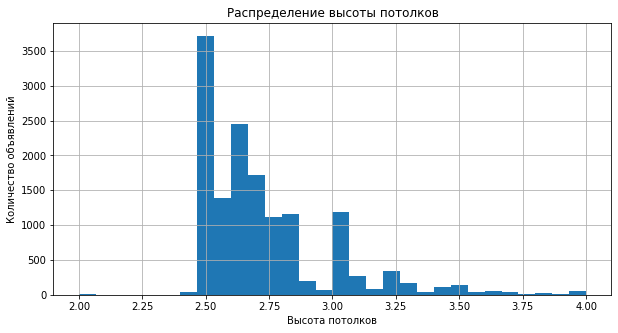

In [63]:
ceil_hist = data['ceiling_height'].hist(bins=30,range=(2, 4), figsize=(10, 5))
ceil_hist.set_title('Распределение высоты потолков')
ceil_hist.set_xlabel('Высота потолков')
ceil_hist.set_ylabel('Количество объявлений')

plt.show()

##### Промежуточный вывод

Закономерности в распределении отсутствуют, но снова есть шипы. \
2.50, 2.65 и 3.00 метра - вот самые распространенные значения. \
И снова причина та же - типовая застройка и стандартные значения для потолков.

#### Тип этажа квартиры

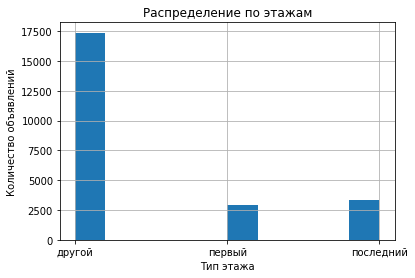

In [64]:
floor_hist = data['type_of_floor'].hist()
floor_hist.set_title('Распределение по этажам')
floor_hist.set_xlabel('Тип этажа')
floor_hist.set_ylabel('Количество объявлений')

plt.show()

Приблизительно равное количество квартир находятся на первом и последнем этажах - их одинаково мало.

#### Общее количество этажей в доме

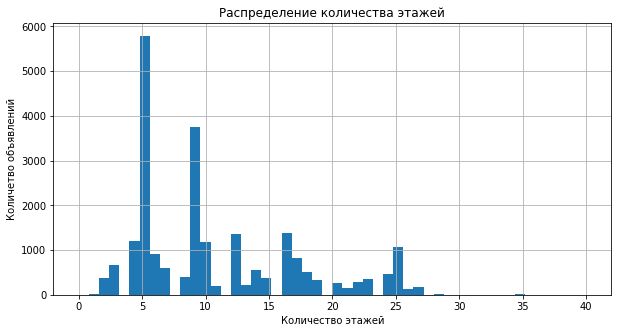

In [65]:
floors_hist = data['floors_total'].hist(bins=50, range=(0, 40), figsize=(10, 5))
floors_hist.set_title('Распределение количества этажей')
floors_hist.set_xlabel('Количество этажей')
floors_hist.set_ylabel('Количетво объявлений')

plt.show()

In [66]:
len(data.query('floors_total == 5'))

5788

In [67]:
len(data.query('floors_total == 9'))

3761

##### Промежуточный вывод

Кстати, о типовой застройке - мы снова видим пики. 5 и 9 этажей - это классическое количество этажей для домов в любом городе. Собственно, это мы и видим - почти 10 тысяч значений именно такие. \
В остальных случаях закономерностей нет.

#### Расстояние до центра города в метрах

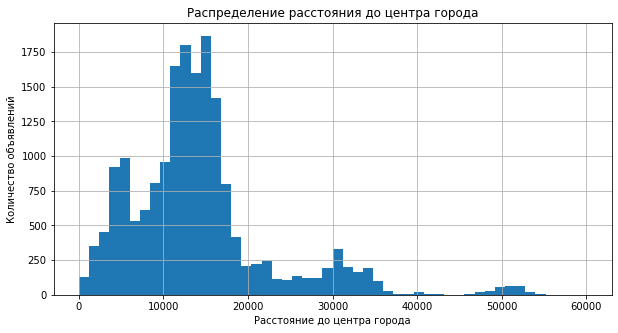

In [68]:
center_hist = data['cityCenters_nearest'].hist(bins=50, range=(1, 60000), figsize=(10, 5))
center_hist.set_title('Распределение расстояния до центра города')
center_hist.set_xlabel('Расстояние до центра города')
center_hist.set_ylabel('Количество объявлений')

plt.show()

##### Промежуточный вывод

Закономерностей распределения не видно, но этот параметр, скорее всего, будет иметь корреляцию с ценой квартиры.

#### Расстояние до ближайшего парка

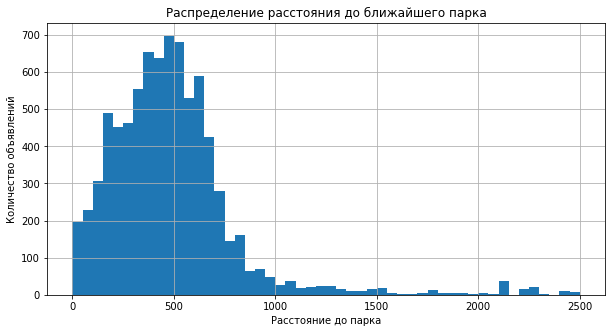

In [69]:
parks_hist = data['parks_nearest'].hist(bins=50, range=(1, 2500), figsize=(10, 5))
parks_hist.set_title('Распределение расстояния до ближайшего парка')
parks_hist.set_xlabel('Расстояние до парка')
parks_hist.set_ylabel('Количество объявлений')

plt.show()

Так как во время предобработки данных мы заменили NaN на 0, исключаем их из гистограммы при помощи параметра `range`. 

Как мы можем заметить, в целом значений очень мало. Это значит, что в достаточно серьезной части объявлений продавцы либо не указали имеющиеся в окрестности парки, либо их нет.

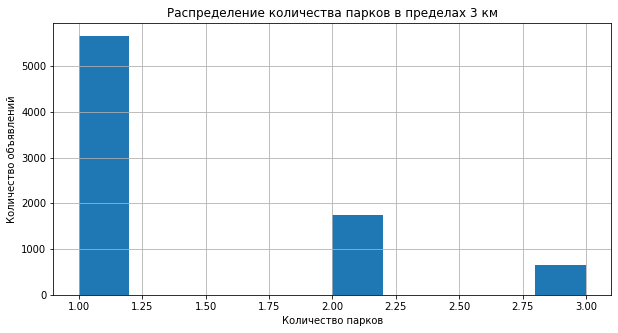

In [70]:
parks_around_hist = data['parks_around3000'].hist(range=(1, 3), figsize=(10, 5))
parks_around_hist.set_title('Распределение количества парков в пределах 3 км')
parks_around_hist.set_xlabel('Количество парков')
parks_around_hist.set_ylabel('Количество объявлений')

plt.show()

Фактически, это та же самая гистограмма, но построенная на данных о количестве парков в радиусе 3км от квартиры.

#### Как быстро продавались квартиры?

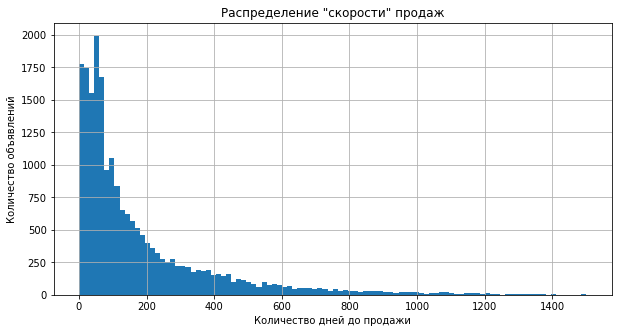

In [71]:
days_hist = data['days_exposition'].hist(bins=100, range=(0, 1500), figsize=(10, 5))
days_hist.set_title('Распределение "скорости" продаж')
days_hist.set_xlabel('Количество дней до продажи')
days_hist.set_ylabel('Количество объявлений')

plt.show()

Для определения среднего и медианы воспользуемся методом `describe()`

In [72]:
data['days_exposition'].describe()

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее - ровно полгода. \
А вот с медианой интереснее - 95 дней, то есть всего три месяца. Это в два раза меньше среднего. \
С чем это связано? У нас есть несколько очень больших значений (несколько лет), которые очень сильно искажают данные.

Поэтому при ответе на вопрос "Сколько обычно занимает продажа?", стоит называть медианное значений - около 3-4 месяцев, так как более половины значений меньше, чем медиана. 

Какие продажи можно считать быстрыми, а какие — необычно долгими? 

Наиболее логичным вариантом при таком разбросе будет смотреть на квартили распределения. Необычно быстрыми будем считать те объявления, в которых значение `days_exposition` меньше значения первого квартиля. Слишком долгими будем считать такие, в которых тоже значение >232 дней.

Сколько обычно занимает продажа: около 95 дней.
Быстрые продажи: менее 95 дней.
Необычно долгие продажи: более 232 дней.

In [73]:
len(data.query('days_exposition < 45'))

5076

In [74]:
len(data.query('days_exposition > 232'))

5083

#### Зависит ли цена от общей площади?

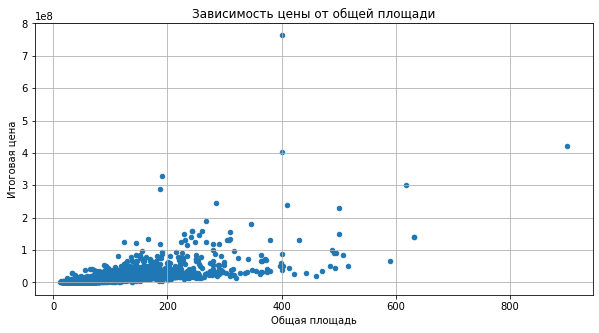

In [75]:
total_area_plot = data.sort_values('total_area').plot(x='total_area', y='last_price', kind='scatter', 
                                     figsize=(10, 5), grid=True)
total_area_plot.set_title('Зависимость цены от общей площади')
total_area_plot.set_xlabel('Общая площадь')
total_area_plot.set_ylabel('Итоговая цена')

plt.show()

In [76]:
data['total_area'].corr(data['last_price'])

0.6535810085611219

У двух исследуемых величин достаточно высокая корреляция. Также на графике заметна зависимость - при повышении метража постепенно повышается стоимость объекта.

Да, цена зависит от общей площади объекта, причем достаточно сильно.

#### Зависит ли цена от жилой площади?

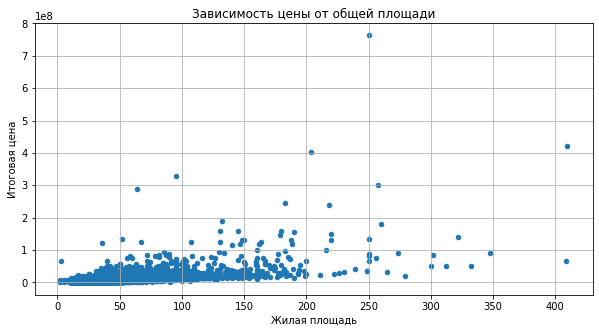

In [77]:
living_area_plot = data.sort_values('living_area').plot(x='living_area', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
living_area_plot.set_title('Зависимость цены от общей площади')
living_area_plot.set_xlabel('Жилая площадь')
living_area_plot.set_ylabel('Итоговая цена')

plt.show()

In [78]:
data['living_area'].corr(data['last_price'])

0.5663955721081748

Корреляция также достаточно высокая, но ниже, чем в прошлом пункте. С чем это может быть связано? Скорее всего,  некоторые продавцы меньше обращают внимание на такие параметры, как жилая площадь, когда выставляют объявление о продаже. В связи с чем, корреляция снижается.

Тем не менее, и график, и значение коэффициента Пирсона говорят нам о том, что жилая площадь также является одним из параметров, влияющих на стоимость.

#### Зависит ли цена от площади кухни?

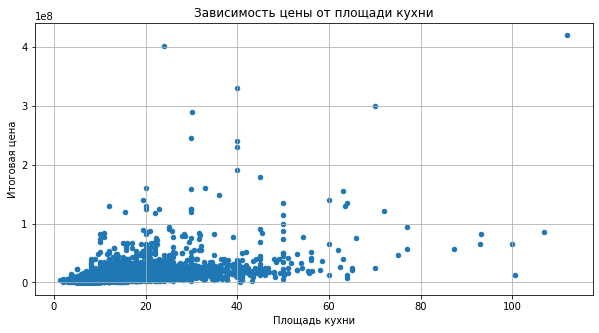

In [79]:
kitchen_area_plot = data.sort_values('kitchen_area').plot(x='kitchen_area', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
kitchen_area_plot.set_title('Зависимость цены от площади кухни')
kitchen_area_plot.set_xlabel('Площадь кухни')
kitchen_area_plot.set_ylabel('Итоговая цена')

plt.show()

In [80]:
data['kitchen_area'].corr(data['last_price'])

0.5200184586898168

Корреляция стала еще ниже, да и график не растет особо...

Площадь кухни влияет на цену квартиры даже меньше, чем жилплощадь. Тем не менее, значение корреляции в 0.52 говорит о том, что взаимосвязь у этих данных все же есть, но не такая сильная.

Тем не менее, сделать вывод о том, что площадь кухни в квартире (как и любая площадь в квартире) влияет на ее цену.

#### Зависит ли цена от количества комнат?

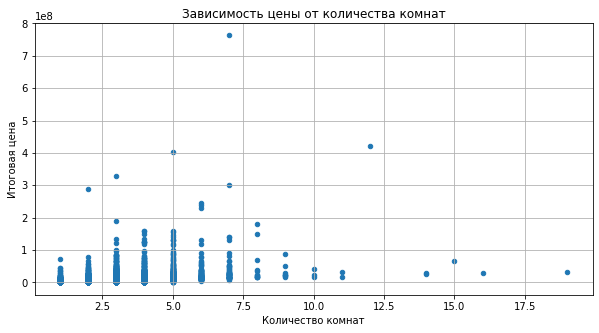

In [81]:
rooms_plot = data.sort_values('rooms').plot(x='rooms', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
rooms_plot.set_title('Зависимость цены от количества комнат')
rooms_plot.set_xlabel('Количество комнат')
rooms_plot.set_ylabel('Итоговая цена')

plt.show()

In [82]:
data['rooms'].corr(data['last_price'])

0.36497536371376443

На 4-хкомнатных квартирах цена перестает вести себя линейно по отношению к количеству комнат. Либо зависимость тут более сложная, либо для больших квартир ценообразование отличается. Скорее всего, второе. К примеру, чем больше площадь, тем больше и квартира.

Значение коэффициента корреляции Пирсона тоже не очень велико, и скорее получилось случайно, так как в данных просто есть схожесть. 

Количество комнат в квартире влияет на ценообразование, если в квартире комнат меньше, чем 5. В остальных случаях - нет.

#### Зависит ли цена от этажа?

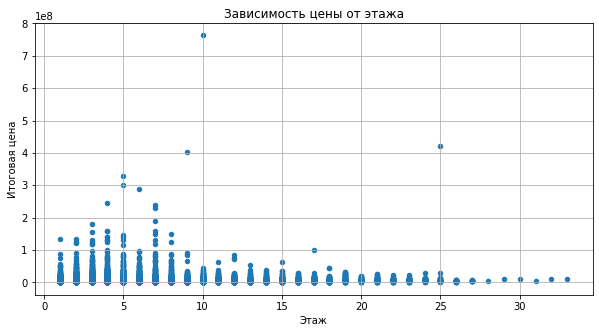

In [83]:
floor_plot = data.plot(x='floor', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
floor_plot.set_title('Зависимость цены от этажа')
floor_plot.set_xlabel('Этаж')
floor_plot.set_ylabel('Итоговая цена')

plt.show()

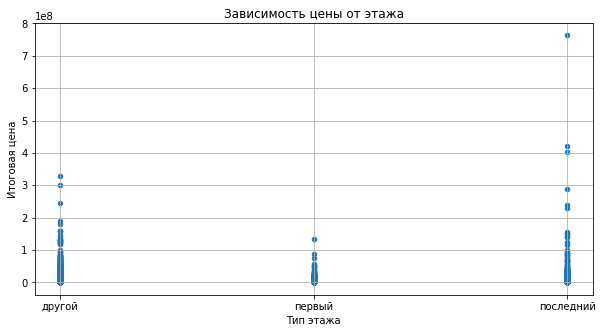

In [84]:
type_floor_plot = data.plot(x='type_of_floor', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
type_floor_plot.set_title('Зависимость цены от этажа')
type_floor_plot.set_xlabel('Тип этажа')
type_floor_plot.set_ylabel('Итоговая цена')

plt.show()

Зависимость отсутствует, из первого графика тоже ничего дельного не извлечь. 

Исходя из второго, можно сделать вывод о том что стоимость квартир на первом этаже минимальна - менее полутора миллионов. Про последний и иные этажи сказать ничего нельзя - цена там может быть любой.

#### Зависит ли цена от даты размещения?

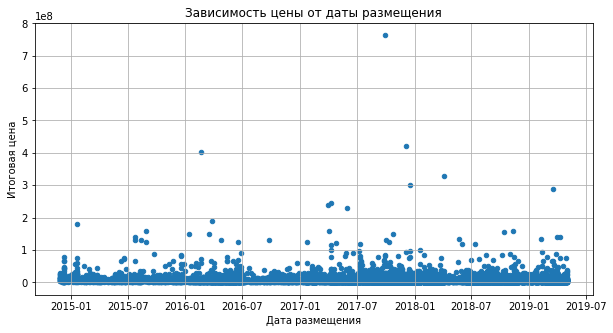

In [85]:
first_day_plot = data.plot(x='first_day_exposition', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
first_day_plot.set_title('Зависимость цены от даты размещения')
first_day_plot.set_xlabel('Дата размещения')
first_day_plot.set_ylabel('Итоговая цена')

plt.show()

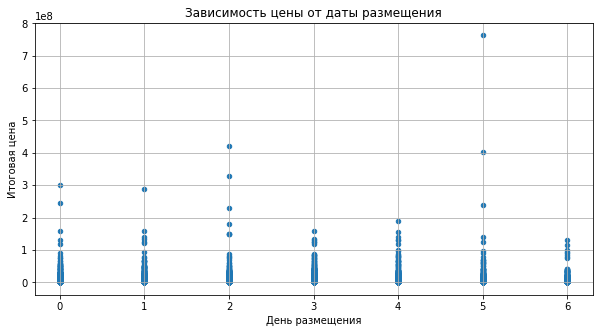

In [86]:
day_plot = data.plot(x='day_exposition', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
day_plot.set_title('Зависимость цены от даты размещения')
day_plot.set_xlabel('День размещения')
day_plot.set_ylabel('Итоговая цена')

plt.show()

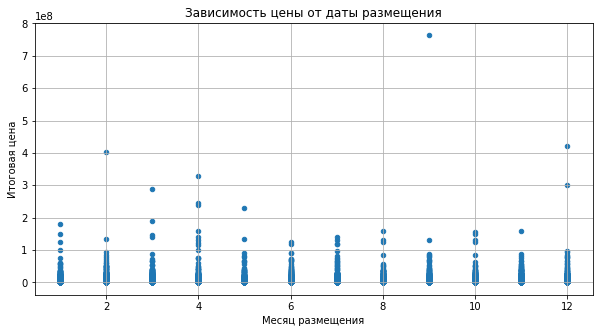

In [87]:
month_plot = data.plot(x='month_exposition', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
month_plot.set_title('Зависимость цены от даты размещения')
month_plot.set_xlabel('Месяц размещения')
month_plot.set_ylabel('Итоговая цена')

plt.show()

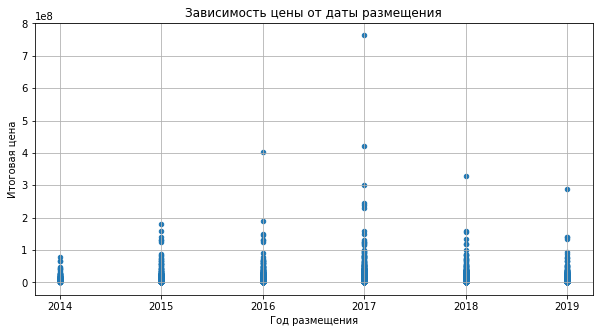

In [88]:
year_plot = data.plot(x='year_exposition', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
year_plot.set_title('Зависимость цены от даты размещения')
year_plot.set_xlabel('Год размещения')
year_plot.set_ylabel('Итоговая цена')

plt.show()

Как мы можем видеть, никаких закономерностей в том, в какой день/месяц/год было размещено объявление. Следовательно, дата размещения не является фактором, влияющим на цену квартиры. 

Тем не менее, больше всего дорогих квартир был размещено в 2017 году.

#### Средняя цена квадратного метра

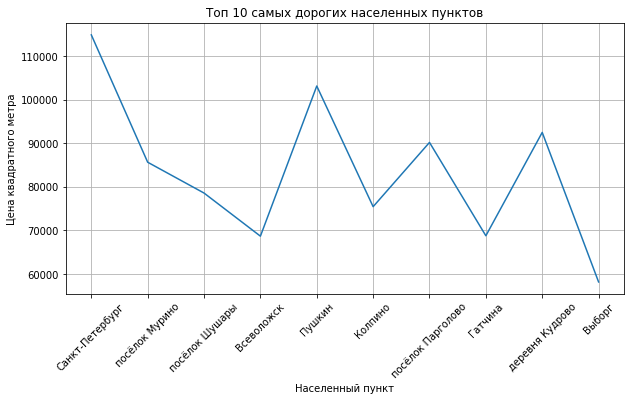

In [89]:
metre_price = data.pivot_table(index='locality_name', values='price_of_a_metre', 
                 aggfunc=['count', 'mean'])

metre_price.columns = ['count', 'price_of_a_metre']

top_10_metre = metre_price.sort_values(by='count', ascending=False).head(10)
top_10_metre_plot = top_10_metre['price_of_a_metre'].plot(kind='line', figsize=(10, 5), grid=True, legend=False)
top_10_metre_plot.set_title('Топ 10 самых дорогих населенных пунктов')
top_10_metre_plot.set_xlabel('Населенный пункт')
top_10_metre_plot.set_ylabel('Цена квадратного метра')
top_10_metre_plot.set_xticks(range(len(top_10_metre.index)))
top_10_metre_plot.set_xticklabels(top_10_metre.index, rotation=45)

plt.show()

In [90]:
top_10_metre

,count,price_of_a_metre
locality_name,,
Санкт-Петербург,15651,114868.877339
посёлок Мурино,552,85629.568641
посёлок Шушары,439,78551.344647
Всеволожск,398,68654.473970
Пушкин,369,103125.819377
Колпино,338,75424.579112
посёлок Парголово,327,90175.913089
Гатчина,307,68746.146515
деревня Кудрово,299,92473.547559


Очевидно, что в Санкт-Петербурге наибольшее число объявлений, а средняя цена квадратного метра там - почти 115 тысяч.

In [91]:
top_10_metre.sort_values(by='price_of_a_metre')

,count,price_of_a_metre
locality_name,,
Выборг,237,58141.909325
Всеволожск,398,68654.473970
Гатчина,307,68746.146515
Колпино,338,75424.579112
посёлок Шушары,439,78551.344647
посёлок Мурино,552,85629.568641
посёлок Парголово,327,90175.913089
деревня Кудрово,299,92473.547559
Пушкин,369,103125.819377


Среди населенных пунктов с самым большим количеством объявлений самый девешый квадратный метр в Выборге - всего 58 тысяч.

In [92]:
metre_price.sort_values('price_of_a_metre').head(5)

,count,price_of_a_metre
locality_name,,
деревня Старополье,3,11206.22
посёлок станции Свирь,2,11481.48
деревня Вахнова Кара,1,11688.31
деревня Выскатка,2,12335.48
посёлок Совхозный,2,12629.13


А вот среди всех населенных пунктов из датасета, наименьшую цену квадратного метра имеет некое Старополье: чуть больше 11000 рублей.

#### What’s the price of a mile?

In [93]:
data_spb = data[data['locality_name'] == 'Санкт-Петербург']

data_spb_distance = data_spb.pivot_table(index='distance_to_the_center', values='last_price', aggfunc='mean')
data_spb_distance.columns = ['avg_price']
data_spb_distance

,avg_price
distance_to_the_center,
0,2.070766e+07
1,2.120672e+07
2,1.778832e+07
3,1.113739e+07
4,1.330428e+07
5,1.445600e+07
6,1.533842e+07
7,1.477515e+07
8,9.949111e+06


<AxesSubplot:xlabel='distance_to_the_center'>

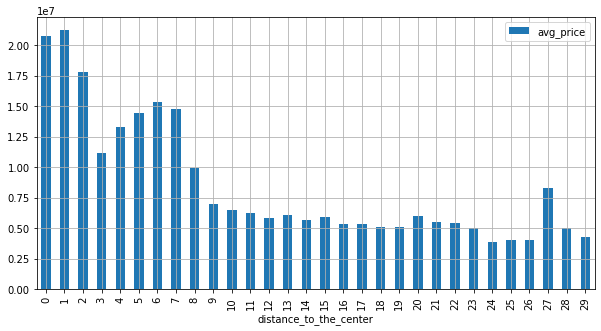

In [94]:
data_spb_distance.plot(kind='bar', figsize=(10, 5), grid=True)

Как и ожидалось, самые дорогие квартиры в центре города и рядом с ним.
На втором километре заметно резкое снижение - с 17 млн до 10.5 млн. 
После следует небольшой подъем до 15 миллионов на шестом километре от центра, а после 9-го цена уже не сильно зависит от приближенности к центру города.

Также наблюдается выброс на 27 км от центра города. Что это?

In [95]:
data_spb.query('distance_to_the_center == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_a_metre,day_exposition,month_exposition,year_exposition,type_of_floor,distance_to_the_center
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,1496.0,0.0,0.0,128.0,193918.92,1,11,2017,другой,27
5961,6,2250000.0,32.0,2018-02-27,1,NaN,2,16.5,2,False,...,0.0,0.0,0.0,178.0,70312.50,1,2,2018,последний,27


Ничего необычного, всего лишь главная проблема среднего - выбросы. Тут одна квартира продается за 14.5 млн, а вторая всего за 2.25 миллиона. Среднее у них около 8, что и дает нам такой пик на графике.

#### Промежуточный вывод для пункта №4

В этом разделе были проанализированы различные факторы, которые могут влиять на цену квартиры (общая площадь, жилая площадь, этаж, дата размещения).

Построены гистограммы для многих столбцов, изучены данные в них и как они могут влиять на итоговый результат.

После проведенного анализа мы можем сказать, что цена зависит от:

1) Общей площади квартиры
2) Жилой площади квартиры
3) Площади кухни 
4) В некоторых случаях от количества комнат (если их меньше 5)

Также есть факторы, которые не имеют никакого отношения к цене квартиры - в первую очередь это дата размещения. \
Стоит отметить, что на первом этаже обычно квартиры дешевле, чем на других.

Были исследованы населенные пункты с самых дорогим квадратным метром, а также изучены самые дешевые населенные пункты. \
Как и следовало ожидать, дороже всего квадрат в Питере, как и в целом квартиры. 

Была изучена зависимость средней цены квартиры в Санкт-Петербурге от удаленности от центра города. Очевидно, в центре квартиры дороже всего - в среднем более 20 млн рублей.

### Общий вывод

В ходе исследования рынка недвижимости в Санкт-Петербурге и его окрестностях, проведенного на основе данных сервиса Яндекс Недвижимость, были выявлены следующие основные факторы, влияющие на стоимость квартиры:

1. Общая площадь квартиры
2. Жилая площадь квартиры
3. Площадь кухни (в меньшей степени)
4. Количество комнат (только для квартир с количеством комнат менее 5)

Было установлено, что такие факторы, как этаж, дата размещения объявления и удаленность от центра города (в некоторых случаях) не имеют видимой связи со стоимостью квартиры.

Также были выявлены различия в средней стоимости квадратного метра в разных населенных пунктах. Самая высокая стоимость квадратного метра зафиксирована в Санкт-Петербурге, а самая низкая - в Старополье.

В центре Санкт-Петербурга квартиры стоят дороже всего, а при удалении от центра цена постепенно снижается. Однако на расстоянии более 9 км от центра города цена уже не сильно зависит от удаленности.

Данные результаты исследования могут быть использованы для создания автоматизированной системы отслеживания аномалий и мошеннической деятельности на рынке недвижимости.